<a href="https://colab.research.google.com/github/ArjunChandwadkar/quant-options-engine/blob/main/Options_Engine_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

Live NIFTY spot from Yahoo: 26175.75
Option chain snapshot:
   strike       expiry  call_last_price  call_oi  call_change_oi  \
0   23750  02-Dec-2025          2450.00      9.0            -2.0   
1   23800  02-Dec-2025          2380.00     10.0            -3.0   
2   23850  02-Dec-2025          2381.20      2.0             1.0   
3   23900  02-Dec-2025          2275.25     12.0            -4.0   
4   23950  02-Dec-2025          2192.00      2.0             0.0   

   put_last_price   put_oi  put_change_oi  
0            0.35  35979.0       -14990.0  
1            0.35  23555.0       -12948.0  
2            0.40   1082.0        -1558.0  
3            0.35   6414.0        -8281.0  
4            0.35    956.0          -54.0  

Using expiry: 24-Feb-2026, T=0.2301 years
ATM strike ~ 26200, call=803.0, put=357.85
Call IV ≈ 12.48%
Put  IV ≈ 10.20%
Asset: NIFTY
Inputs: S=26175.75, K=26200, r=0.06, sigma=0.1248, T=0.230137
----------------------------------------
Call Price: 803.0000
Put  Price

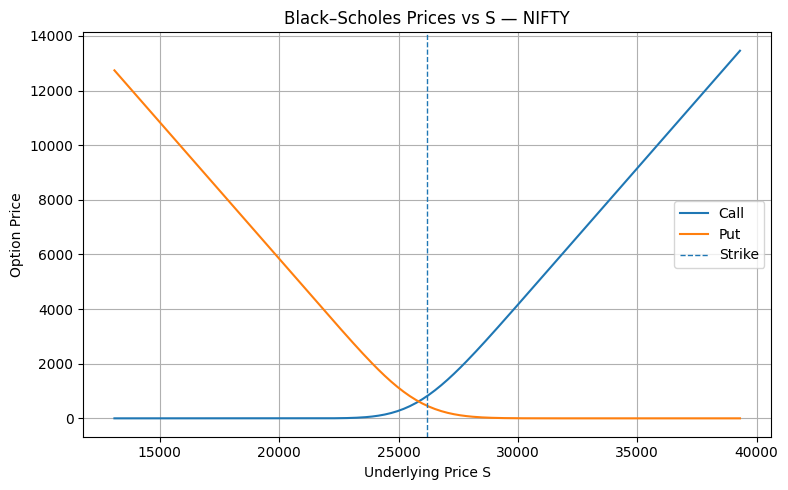

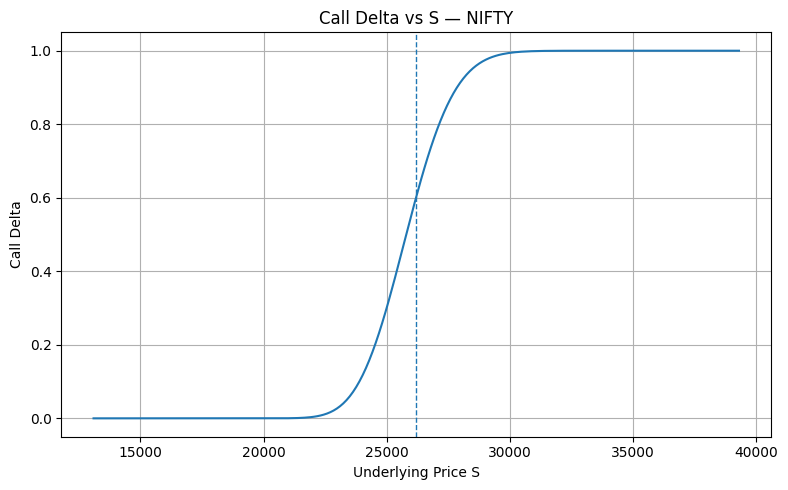

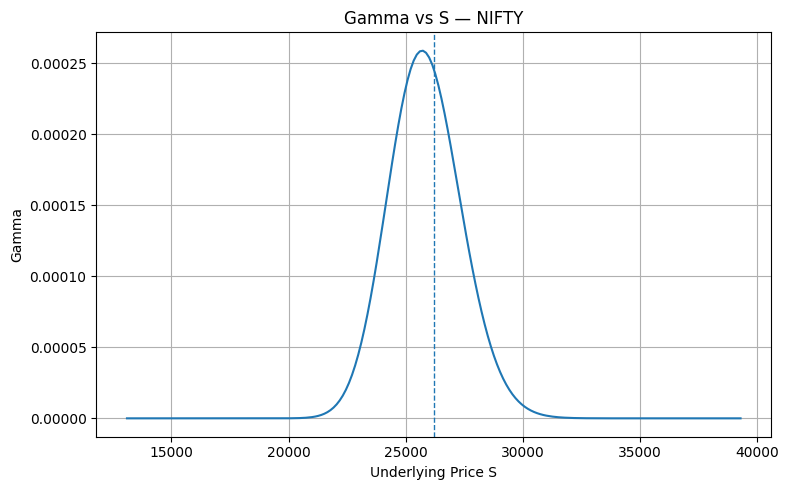

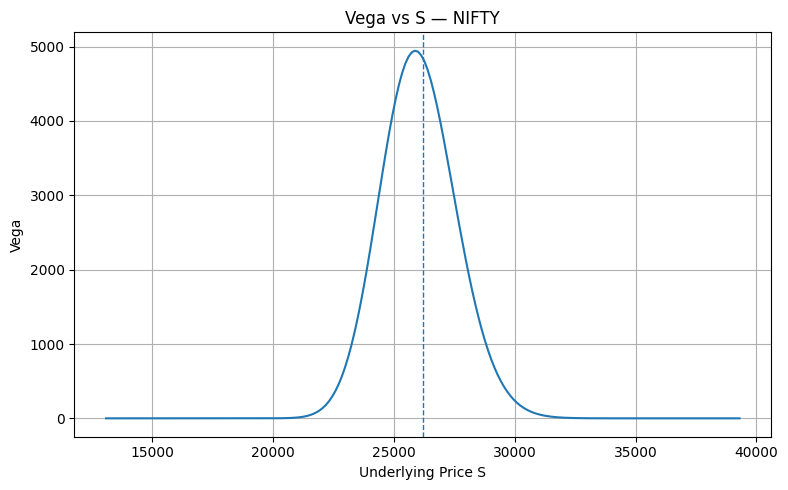

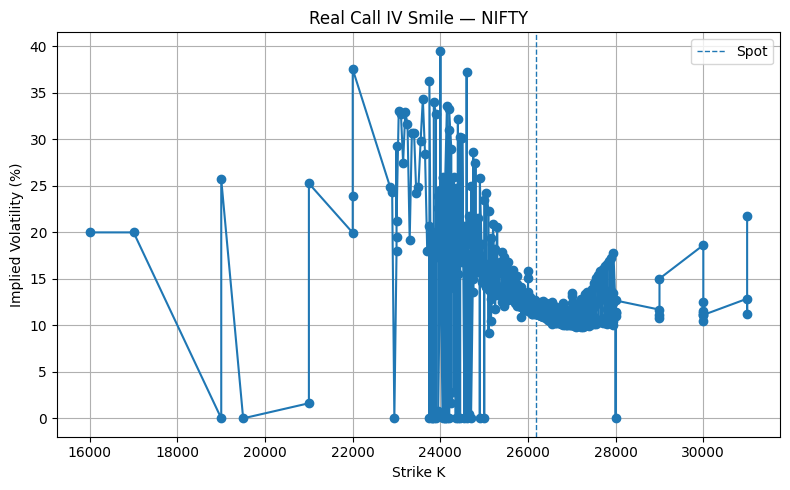

In [13]:
"""
options_engine.py

A small quantitative options pricing engine:
- Fetches real NIFTY data
- Prices options with Black–Scholes
- Computes Greeks
- Computes implied vol for calls & puts
- Builds basic IV smile from live option-chain
"""

# ================================
# Imports
# ================================
import math
import time
from datetime import datetime

import numpy as np
import pandas as pd
import requests
import yfinance as yf
import matplotlib.pyplot as plt

# ================================
# Data Ingestion (REAL MARKET DATA)
# ================================

def get_underlying_price(ticker_symbol: str):
    """
    Returns the latest close price for the given ticker using yfinance.
    Examples:
        '^NSEI' for NIFTY 50
        'RELIANCE.NS' for Reliance on NSE
        'AAPL' for Apple (US)
    """
    ticker = yf.Ticker(ticker_symbol)
    data = ticker.history(period="1d")
    if data.empty:
        return None
    return float(data["Close"].iloc[-1])


def get_nifty_option_chain():
    """
    Fetches NIFTY option chain from NSE's public endpoint.
    Returns the raw JSON dict.
    NOTE: This may fail sometimes if NSE blocks bots or changes the API.
    """
    url = "https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY"
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/100.0.4896.127 Safari/537.36"
        ),
        "Accept-Language": "en-US,en;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
    }

    session = requests.Session()
    # warm up cookies
    session.get("https://www.nseindia.com", headers=headers, timeout=10)
    time.sleep(1)
    resp = session.get(url, headers=headers, timeout=10)
    resp.raise_for_status()
    data = resp.json()
    return data


def parse_option_chain_to_df(oc_json: dict) -> pd.DataFrame:
    """
    Takes NSE option-chain JSON and returns a DataFrame
    with useful call/put info for each strike/expiry.
    """
    records = oc_json.get("records", {}).get("data", [])
    rows = []

    for rec in records:
        strike = rec.get("strikePrice")
        expiry = rec.get("expiryDate")

        ce = rec.get("CE", None)
        pe = rec.get("PE", None)

        row = {"strike": strike, "expiry": expiry}

        if ce:
            row.update(
                {
                    "call_last_price": ce.get("lastPrice"),
                    "call_oi": ce.get("openInterest"),
                    "call_change_oi": ce.get("changeinOpenInterest"),
                }
            )
        else:
            row.update(
                {
                    "call_last_price": None,
                    "call_oi": None,
                    "call_change_oi": None,
                }
            )

        if pe:
            row.update(
                {
                    "put_last_price": pe.get("lastPrice"),
                    "put_oi": pe.get("openInterest"),
                    "put_change_oi": pe.get("changeinOpenInterest"),
                }
            )
        else:
            row.update(
                {
                    "put_last_price": None,
                    "put_oi": None,
                    "put_change_oi": None,
                }
            )

        rows.append(row)

    df = pd.DataFrame(rows)
    df = df.dropna(subset=["call_last_price", "put_last_price"], how="all")
    df = df.sort_values(["expiry", "strike"])
    return df.reset_index(drop=True)


def compute_T_years(expiry_str: str) -> float:
    """
    Converts NSE expiry string like '30-Jan-2025' into time to expiry in years.
    """
    try:
        expiry = datetime.strptime(expiry_str, "%d-%b-%Y")
    except ValueError:
        return 0.0
    today = datetime.now()
    days = (expiry - today).days
    return max(days, 0) / 365.0

# ================================
# Core Black–Scholes Math
# ================================

def norm_pdf(x: float) -> float:
    return (1.0 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * x * x)


def norm_cdf(x: float) -> float:
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))


def d1(S: float, K: float, r: float, sigma: float, T: float) -> float:
    return (math.log(S / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * math.sqrt(T))


def d2(S: float, K: float, r: float, sigma: float, T: float) -> float:
    return d1(S, K, r, sigma, T) - sigma * math.sqrt(T)


def bs_call_price(S: float, K: float, r: float, sigma: float, T: float) -> float:
    D1 = d1(S, K, r, sigma, T)
    D2 = d2(S, K, r, sigma, T)
    return S * norm_cdf(D1) - K * math.exp(-r * T) * norm_cdf(D2)


def bs_put_price(S: float, K: float, r: float, sigma: float, T: float) -> float:
    D1 = d1(S, K, r, sigma, T)
    D2 = d2(S, K, r, sigma, T)
    return K * math.exp(-r * T) * norm_cdf(-D2) - S * norm_cdf(-D1)

# ================================
# Greeks
# ================================

def call_delta(S, K, r, sigma, T):
    return norm_cdf(d1(S, K, r, sigma, T))


def put_delta(S, K, r, sigma, T):
    return norm_cdf(d1(S, K, r, sigma, T)) - 1.0


def gamma(S, K, r, sigma, T):
    return norm_pdf(d1(S, K, r, sigma, T)) / (S * sigma * math.sqrt(T))


def vega(S, K, r, sigma, T):
    return S * norm_pdf(d1(S, K, r, sigma, T)) * math.sqrt(T)


def call_theta(S, K, r, sigma, T):
    D1 = d1(S, K, r, sigma, T)
    D2 = d2(S, K, r, sigma, T)
    term1 = (-S * norm_pdf(D1) * sigma) / (2 * math.sqrt(T))
    term2 = -r * K * math.exp(-r * T) * norm_cdf(D2)
    return term1 + term2


def put_theta(S, K, r, sigma, T):
    D1 = d1(S, K, r, sigma, T)
    D2 = d2(S, K, r, sigma, T)
    term1 = (-S * norm_pdf(D1) * sigma) / (2 * math.sqrt(T))
    term2 = r * K * math.exp(-r * T) * norm_cdf(-D2)
    return term1 + term2


def call_rho(S, K, r, sigma, T):
    D2 = d2(S, K, r, sigma, T)
    return T * K * math.exp(-r * T) * norm_cdf(D2)


def put_rho(S, K, r, sigma, T):
    D2 = d2(S, K, r, sigma, T)
    return -T * K * math.exp(-r * T) * norm_cdf(-D2)

# ================================
# Implied Volatility Solvers
# ================================

def implied_volatility_call(S, K, r, T, market_price, initial_guess=0.2,
                            max_iter=100, tol=1e-6):
    sigma = initial_guess
    for _ in range(max_iter):
        price = bs_call_price(S, K, r, sigma, T)
        diff = price - market_price
        if abs(diff) < tol:
            break
        v = vega(S, K, r, sigma, T)
        if v < 1e-8:
            break
        sigma = sigma - diff / v
        sigma = max(sigma, 1e-4)
    return sigma


def implied_volatility_put(S, K, r, T, market_price, initial_guess=0.2,
                           max_iter=100, tol=1e-6):
    sigma = initial_guess
    for _ in range(max_iter):
        price = bs_put_price(S, K, r, sigma, T)
        diff = price - market_price
        if abs(diff) < tol:
            break
        v = vega(S, K, r, sigma, T)
        if v < 1e-8:
            break
        sigma = sigma - diff / v
        sigma = max(sigma, 1e-4)
    return sigma

# ================================
# Summary / Reporting
# ================================

def summarize_option(asset_name, S, K, r, sigma, T):
    c = bs_call_price(S, K, r, sigma, T)
    p = bs_put_price(S, K, r, sigma, T)

    print(f"Asset: {asset_name}")
    print(f"Inputs: S={S:.2f}, K={K}, r={r}, sigma={sigma:.4f}, T={T:.6f}")
    print("-" * 40)
    print(f"Call Price: {c:.4f}")
    print(f"Put  Price: {p:.4f}")
    print()
    print(f"Call Delta: {call_delta(S, K, r, sigma, T):.4f}")
    print(f"Put  Delta: {put_delta(S, K, r, sigma, T):.4f}")
    print(f"Gamma     : {gamma(S, K, r, sigma, T):.6f}")
    print(f"Vega      : {vega(S, K, r, sigma, T):.4f}")
    print(f"Call Theta: {call_theta(S, K, r, sigma, T):.4f}")
    print(f"Put  Theta: {put_theta(S, K, r, sigma, T):.4f}")
    print(f"Call Rho  : {call_rho(S, K, r, sigma, T):.4f}")
    print(f"Put  Rho  : {put_rho(S, K, r, sigma, T):.4f}")

# ================================
# Plotting
# ================================

def plot_option_prices_vs_S(asset_name, K, r, sigma, T):
    S_values = np.linspace(0.5 * K, 1.5 * K, 200)
    call_prices = [bs_call_price(S, K, r, sigma, T) for S in S_values]
    put_prices = [bs_put_price(S, K, r, sigma, T) for S in S_values]

    plt.figure(figsize=(8, 5))
    plt.plot(S_values, call_prices, label="Call")
    plt.plot(S_values, put_prices, label="Put")
    plt.axvline(K, linestyle="--", linewidth=1, label="Strike")
    plt.xlabel("Underlying Price S")
    plt.ylabel("Option Price")
    plt.title(f"Black–Scholes Prices vs S — {asset_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_greeks_vs_S(asset_name, K, r, sigma, T):
    S_values = np.linspace(0.5 * K, 1.5 * K, 200)
    deltas = [call_delta(S, K, r, sigma, T) for S in S_values]
    gammas = [gamma(S, K, r, sigma, T) for S in S_values]
    vegas = [vega(S, K, r, sigma, T) for S in S_values]

    # Delta
    plt.figure(figsize=(8, 5))
    plt.plot(S_values, deltas)
    plt.axvline(K, linestyle="--", linewidth=1)
    plt.xlabel("Underlying Price S")
    plt.ylabel("Call Delta")
    plt.title(f"Call Delta vs S — {asset_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Gamma
    plt.figure(figsize=(8, 5))
    plt.plot(S_values, gammas)
    plt.axvline(K, linestyle="--", linewidth=1)
    plt.xlabel("Underlying Price S")
    plt.ylabel("Gamma")
    plt.title(f"Gamma vs S — {asset_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Vega
    plt.figure(figsize=(8, 5))
    plt.plot(S_values, vegas)
    plt.axvline(K, linestyle="--", linewidth=1)
    plt.xlabel("Underlying Price S")
    plt.ylabel("Vega")
    plt.title(f"Vega vs S — {asset_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ================================
# Real-data IV Smile from NSE chain
# ================================

def plot_real_call_iv_smile(asset_name: str, S: float, r: float,
                            df_chain: pd.DataFrame, expiry_filter: str = None):
    """
    Build a real IV smile using live call prices from NSE chain.
    Uses nearest expiry by default, or a specific expiry string if given.
    """
    df = df_chain.copy()

    if expiry_filter:
        df = df[df["expiry"] == expiry_filter]

    # If no filter, choose nearest expiry by days
    if df.empty:
        print("No option data for selected expiry.")
        return

    df["T"] = df["expiry"].apply(compute_T_years)
    df = df[df["T"] > 0]

    iv_list = []
    strikes = []

    for _, row in df.iterrows():
        K = row["strike"]
        call_price = row["call_last_price"]
        T = row["T"]
        if pd.isna(call_price) or call_price <= 0:
            continue
        try:
            iv = implied_volatility_call(S, K, r, T, call_price, initial_guess=0.20)
            if 0.0 < iv < 3.0:  # filter insane IVs
                iv_list.append(iv)
                strikes.append(K)
        except Exception:
            continue

    if not strikes:
        print("Could not compute any valid implied vols for calls.")
        return

    strikes = np.array(strikes)
    iv_list = np.array(iv_list)

    order = np.argsort(strikes)
    strikes = strikes[order]
    iv_list = iv_list[order]

    plt.figure(figsize=(8, 5))
    plt.plot(strikes, iv_list * 100.0, marker="o")
    plt.axvline(S, linestyle="--", linewidth=1, label="Spot")
    plt.xlabel("Strike K")
    plt.ylabel("Implied Volatility (%)")
    plt.title(f"Real Call IV Smile — {asset_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ================================
# Example main (for quick testing)
# ================================

if __name__ == "__main__":
    asset_name = "NIFTY"
    ticker_symbol = "^NSEI"

    S_live = get_underlying_price(ticker_symbol)
    print(f"Live {asset_name} spot from Yahoo: {S_live}")

    oc_json = get_nifty_option_chain()
    df_oc = parse_option_chain_to_df(oc_json)
    print("Option chain snapshot:")
    print(df_oc.head())

    # pick closest-to-spot row
    atm_idx = (df_oc["strike"] - S_live).abs().argsort().iloc[0]
    atm_row = df_oc.iloc[atm_idx]
    K_atm = atm_row["strike"]
    call_mkt = atm_row["call_last_price"]
    put_mkt = atm_row["put_last_price"]
    expiry_str = atm_row["expiry"]
    T = compute_T_years(expiry_str)
    r = 0.06  # rough risk-free

    print(f"\nUsing expiry: {expiry_str}, T={T:.4f} years")
    print(f"ATM strike ~ {K_atm}, call={call_mkt}, put={put_mkt}")

    iv_call = implied_volatility_call(S_live, K_atm, r, T, call_mkt, initial_guess=0.20)
    iv_put = implied_volatility_put(S_live, K_atm, r, T, put_mkt, initial_guess=0.20)
    print(f"Call IV ≈ {iv_call*100:.2f}%")
    print(f"Put  IV ≈ {iv_put*100:.2f}%")

    sigma_demo = iv_call
    summarize_option(asset_name, S_live, K_atm, r, sigma_demo, T)
    plot_option_prices_vs_S(asset_name, K_atm, r, sigma_demo, T)
    plot_greeks_vs_S(asset_name, K_atm, r, sigma_demo, T)
    plot_real_call_iv_smile(asset_name, S_live, r, df_oc)